In [50]:
from utils.lyric_collect import get_whole_song_lyrics
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path
import re
from urllib.parse import urljoin
import neologdn
import pickle
from datetime import datetime as dt

from utils.lyric_tokenizer import base_tokenize


In [51]:
ROOT = Path("./").resolve().parent
SECRETS = ROOT / ".secrets"
DATA = ROOT / "data"
DATA.mkdir(exist_ok=True,parents=True)

In [52]:
def pickle_load(path:str):
    with open(path, mode='rb') as f:
        return pickle.load(f)

### データ収集

In [ ]:
res = requests.get("https://www.uta-net.com/ranking/artist/")
soup = BeautifulSoup(res.text, 'html.parser')

In [ ]:
ranking = pd.DataFrame()
container = soup.select_one("#rank-total-tab")
for i,li in enumerate(container.select("ol.ranking-ol-table li")):
    rank = li.find("div", class_="text-center").get_text(strip=True)
    name = li.find_all("div")[1].get_text(strip=True)
    href = li.find_parent("a")["href"]  # アーティストページURL
    id = href.rstrip("/").split("/")[-1]
    ranking.loc[i,"rank"] = rank
    ranking.loc[i,"artist_id"] = id
    ranking.loc[i,"name"] = name

In [ ]:
LYRICS = DATA / "lyrics"
LYRICS.mkdir(exist_ok=True,parents=True)
execution_date = dt.today().strftime("%Y%m%d")
sample_n = 50
mode = 4

for row in ranking[["artist_id","name"]].iterrows():
    artist_id = row[1]["artist_id"]
    artist_name = row[1]["name"]
    if artist_id == "4002":
        continue
    else:
        data = get_whole_song_lyrics(artist_id, "artist", mode, sample_n,1)
        with open(LYRICS / f"{artist_name}_{execution_date}_mode{mode}_top{sample_n}.pkl", mode='wb') as f:
            pickle.dump(data, f)

In [ ]:
data = [pickle_load(path) for path in LYRICS.glob("*.pkl")]

In [ ]:
df = pd.DataFrame()
i = 0
for li in data:
    for d in li[:50]:
        for k,v in d.items():
            df.loc[i,k] = v
        i += 1
df.release = pd.to_datetime(df.release)
df.to_pickle(DATA/"all_lyrics.pkl")

### 分析

In [53]:
import random
import torch
from bertopic import BERTopic
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sudachipy import tokenizer, dictionary
import numpy as np
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance


In [54]:
OUT = ROOT / "output"
OUT.mkdir(exist_ok=True,parents=True)

In [55]:
# tok = dictionary.Dictionary(dict="full").create()
# SPLIT_MODE = tokenizer.Tokenizer.SplitMode.C  # まずはCから

In [56]:
# EMBED_MODEL_NAME ="paraphrase-multilingual-MiniLM-L12-v2"
EMBED_MODEL_NAME = "sonoisa/sentence-bert-base-ja-mean-tokens-v2"
embed_model = SentenceTransformer(EMBED_MODEL_NAME)

In [57]:
df = pd.read_pickle(DATA/"all_lyrics.pkl")

In [ ]:
# POS_KEEP = {"名詞", "動詞", "形容詞"}
# USER_STOPWORDS = {
#     # "こと","ところ","よう","シリーズ","タイプ"
#     }  # 例：適宜増やす

# def sudachi_tokenize(text: str):
#     out = []
#     for m in tok.tokenize(text, mode):
#         pos0 = m.part_of_speech()[0]
#         if pos0 not in POS_KEEP:
#             continue
#         base = m.dictionary_form()
#         # 数値マスク例：用途に応じてON/OFF
#         # if base.isdigit():
#         #     base = "<NUM>"
#         # if len(base) <= 1:  # 1文字語を削る例
#             # continue
#         if base in USER_STOPWORDS:
#             continue
#         out.append(base)
#     return out

In [ ]:
# vectorizer = CountVectorizer(
#     tokenizer=sudachi_tokenize,
#     token_pattern=None,
#     lowercase=True,
#     ngram_range=(1,2),
#     min_df=5, # 3post以下でしか出現しないまれなワードは除外する
#     # max_df=0.5 # 全体の50%以上のpostで出現する汎用ワードは除外する
# )

In [ ]:
# vectorizer = CountVectorizer(
#     analyzer="char",
#     ngram_range=(3, 5),
#     min_df=2,
#     max_df=0.8,
#     max_features=30000
# )

In [ ]:
# docs = df["lyric"].fillna("").tolist()

# SEED = 12345678
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# umap_model = UMAP( # random_state以外はBERTopicのデフォルト設定
#     n_neighbors=15,
#     n_components=5,
#     min_dist=0.0,
#     metric="cosine",
#     random_state=SEED,
#     )
# min_topic_size = 50 # 1クラスタ当たり最低でもどれだけのPostが所属するかのパラメータ
# top_n_words = 30 # クラスタを代表する単語をcTF-IDFに基づいて取得するTop n
# execution_datetime = dt.today().strftime("%Y%m%d%H%M%S")
# rep = KeyBERTInspired()

# # BERTopic本体
# topic_model = BERTopic(
#     embedding_model=embed_model,
#     vectorizer_model=vectorizer,
#     representation_model=rep,
#     min_topic_size=min_topic_size,
#     nr_topics=None, # トピック数をしていできるが、必ずしもその数通りにはならない。今回はNone
#     top_n_words=top_n_words,
#     umap_model=umap_model,
# )

# topics, probs = topic_model.fit_transform(docs)

# BT_OUT = OUT / f"BERTopic_output_{execution_datetime}"
# BT_OUT.mkdir(exist_ok=True,parents=True)
# path = BT_OUT / "fitted_topic_model.pkl"
# with open(path, mode='wb') as f:
#     pickle.dump(topic_model, f)

# # 概要出力
# topic_info = topic_model.get_topic_info()
# topic_info.to_csv(BT_OUT / "topic_info.csv", index=False, encoding="utf-8-sig")

# # 各トピック上位語 cTF-IDF算出
# topic_words_data = []
# for topic_id in topic_info["Topic"].tolist():
#     if topic_id == -1:
#         continue
#     words = topic_model.get_topic(topic_id)
#     # words は (単語, 重み) のリスト
#     topic_words = pd.DataFrame(words, columns=["word", "weight"])
#     topic_words["topic_id"] = topic_id
#     topic_words_data.append(topic_words)
# topic_words = pd.concat(topic_words_data,axis=0)
# topic_words.index.name = 'rank'
# topic_words = topic_words.reset_index()
# topic_words.to_csv(
#     BT_OUT / f"topic_words_top{top_n_words}.csv",
#     index=False,
#     encoding="utf-8-sig"
#     )

In [ ]:
# POS_KEEP = {"名詞", "形容詞", "動詞","代名詞","連体詞"}  # 好みで調整
# MAX_BYTES = 45000  # 安全マージン。上限(49149)未満に。

# def _byte_chunks(text: str, max_bytes: int = MAX_BYTES):
#     buf, size = [], 0
#     for line in text.splitlines():
#         b = line.encode("utf-8")
#         if len(b) > max_bytes:
#             # 1行が超長いときは句読点でさらに分割
#             for sent in re.split(r'(?<=[。！？\n])', line):
#                 sb = sent.encode("utf-8")
#                 if len(sb) > max_bytes:
#                     # それでも超えるなら切り詰め（最終手段）
#                     yield sb[:max_bytes].decode("utf-8", errors="ignore")
#                 else:
#                     yield sent
#         else:
#             if size + len(b) > max_bytes and buf:
#                 yield "\n".join(buf)
#                 buf, size = [], 0
#             buf.append(line)
#             size += len(b)
#     if buf:
#         yield "\n".join(buf)

# def sudachi_tokenize_safe(text: str):
#     text = text.lower()
#     tokens = []
#     for chunk in _byte_chunks(text):
#         for m in tok.tokenize(chunk, mode):
#             pos0 = m.part_of_speech()[0]
#             if pos0 in POS_KEEP:
#                 tokens.append(m.dictionary_form())
#     return tokens

In [58]:
def tknz(txt):
    KEEPPOS = {"名詞", "形容詞", "動詞", "代名詞", "連体詞", "感動詞"}
    NG = set("ない あ あぁ う この あの その ここ そこ する いる ある なる こと".split(" "))
    return base_tokenize(
        txt,
        keep_pos=KEEPPOS,
        ng_words=NG,
        )

vectorizer = CountVectorizer(
    tokenizer=tknz,
    token_pattern=None,
    lowercase=False,
    ngram_range=(1, 4),
    min_df=1,
    max_df=1.0,
)

In [59]:
docs = df["lyric"].fillna("").tolist()

SEED = 12345678
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
umap_model = UMAP( # random_state以外はBERTopicのデフォルト設定
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=SEED,
    )
min_topic_size = 20 # 1クラスタ当たり最低でもどれだけのPostが所属するかのパラメータ
top_n_words = 30 # クラスタを代表する単語をcTF-IDFに基づいて取得するTop n
execution_datetime = dt.today().strftime("%Y%m%d%H%M%S")

# BERTopic本体
topic_model = BERTopic(
    embedding_model=embed_model,
    vectorizer_model=vectorizer,
    min_topic_size=min_topic_size,
    nr_topics=None, # トピック数をしていできるが、必ずしもその数通りにはならない。今回はNone
    top_n_words=top_n_words,
    umap_model=umap_model,
)

topics, probs = topic_model.fit_transform(docs)

BT_OUT = OUT / f"BERTopic_output_{execution_datetime}"
BT_OUT.mkdir(exist_ok=True,parents=True)
path = BT_OUT / "fitted_topic_model.pkl"
with open(path, mode='wb') as f:
    pickle.dump(topic_model, f)


In [73]:
# BT_OUT = OUT / "BERTopic_output_20251001221119"
path = BT_OUT / "fitted_topic_model.pkl"
topic_model = pickle_load(path)

In [74]:
# 概要出力
topic_info = topic_model.get_topic_info()
topic_info.to_csv(BT_OUT / "topic_info.csv", index=False, encoding="utf-8-sig")

# 各トピック上位語 cTF-IDF算出
topic_words_data = []
for topic_id in topic_info["Topic"].tolist():
    if topic_id == -1:
        continue
    words = topic_model.get_topic(topic_id)
    # words は (単語, 重み) のリスト
    topic_words = pd.DataFrame(words, columns=["word", "weight"])
    topic_words["topic_id"] = topic_id
    topic_words_data.append(topic_words)
topic_words = pd.concat(topic_words_data,axis=0)
topic_words.index.name = 'rank'
topic_words = topic_words.reset_index()
topic_words.to_csv(
    BT_OUT / f"topic_words_top{top_n_words}.csv",
    index=False,
    encoding="utf-8-sig"
    )

In [75]:
# 文書ごとのトピック割当
df['topic'] = topics
df['prob'] = probs
df.to_csv(
    BT_OUT / "topic_results.csv",
    index=False,
    encoding="utf-8-sig",
    )
df.to_pickle(BT_OUT / "topic_results.pkl")

# 視覚化（HTML）
fig = topic_model.visualize_topics()
fig.write_html(str(BT_OUT / "viz_topics.html"))
fig = topic_model.visualize_hierarchy()
fig.write_html(str(BT_OUT / "viz_hierarchy.html"))

### Wordcloud

In [76]:
from wordcloud import WordCloud
import os
from matplotlib import pyplot as plt
if os.name == "nt":
    plt.rcParams["font.family"] = "Meiryo"
elif os.name == "posix":
    plt.rcParams["font.family"] = "Hiragino Sans"

In [77]:
def wc_gen(ax,weight,fontcolor = "#274157",max_w = 30):
    font_path = r"C:\Windows\Fonts\BIZ-UDGothicR.ttc"
    def single_color_func(
            word,
            font_size,
            position,
            orientation,
            random_state=None,
            **kwargs,
            ):
        return fontcolor

    wc = WordCloud(
        width=500,
        height=500,
        max_words=max_w,
        background_color="white",
        colormap=None,
        prefer_horizontal=1,
        font_path=font_path,
        random_state=42,
    ).generate_from_frequencies(weight)
    wc.recolor(color_func=single_color_func)
    ax.imshow(wc, interpolation="bilinear")
    return ax

def show_wc_topics_row(
        from_topic:int,
        to_topic:int,
        topic_words:pd.DataFrame,
        max_w:int,
        topic_info:pd.DataFrame,
        fontcolor:str = "#274157",
        savepath:str|Path|None = None,
        ):
    """
    from_topic : 1始まりの開始トピック番号
    to_topic   : 1始まりの終了トピック番号
    topic_words: columns = ["topic_id","rank","word","weight"]
    fontcolor  : coloercode
    """
    num = to_topic - from_topic + 1
    fig, axes = plt.subplots(
        ncols=num,
        figsize=(num*5,5),
        tight_layout=True,
    )
    axes = np.ravel(axes)
    to_topic = min(to_topic,np.max(topic_words.topic_id)+1)
    for i, topic in enumerate(range(from_topic-1,to_topic)):
        ax = axes[i]
        weight = (
            topic_words
                .loc[topic_words.topic_id == topic, ["word","weight"]]
                .set_index("word",drop=True)
                .sort_values("weight",ascending=False)[:max_w]
                .to_dict()["weight"]
        )
        ax = wc_gen(ax,weight,fontcolor,max_w)
        n = topic_info.loc[topic_info.Topic == topic,"Count"].tolist()[0]
        ax.set_title(f"Topic {topic+1} {n:,.0f}posts", fontsize=20)
    for ax in axes:
        ax.axis("off")
    if savepath:
        plt.savefig(str(savepath),bbox_inches="tight", pad_inches=0.1)
    plt.show()

### Bertopic出力のcTF-IDFベース
`CountVectorizer`で設定した頻度上下限の影響を受ける

In [78]:
np.max(topic_info.Topic) + 1

np.int64(11)

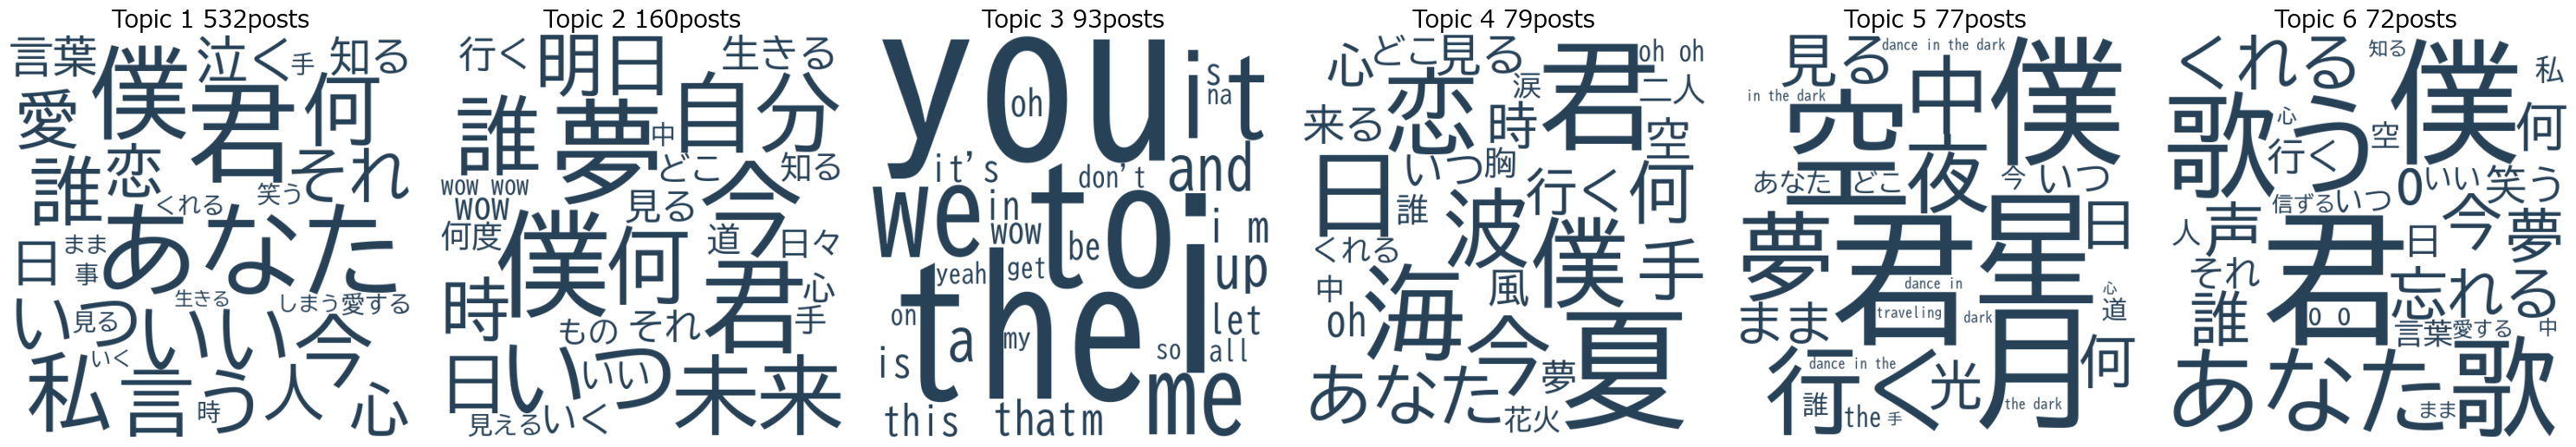

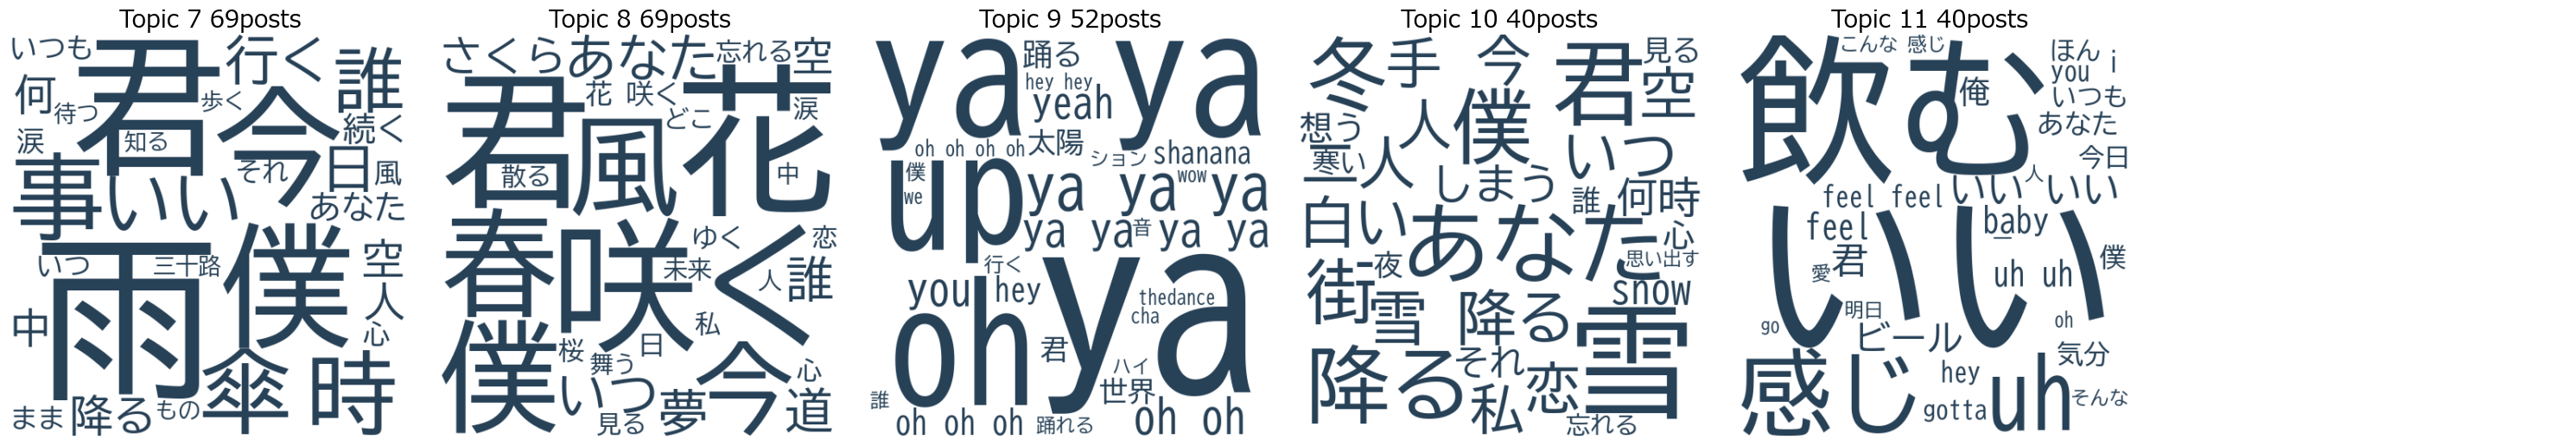

In [79]:
topic_size = np.max(topic_info.Topic) + 1
from_topic = 1
ncols = 6
to_topic = ncols
while from_topic <= topic_size:
    show_wc_topics_row(
            from_topic,
            to_topic,
            topic_words,
            top_n_words,
            topic_info,
            fontcolor = "#274157",
        #     savepath = BT_OUT / f"wc_bertopic_output_topic{from_topic}-{to_topic}.png",
            )
    from_topic += ncols
    to_topic += ncols

#### 分かち書きやり直し

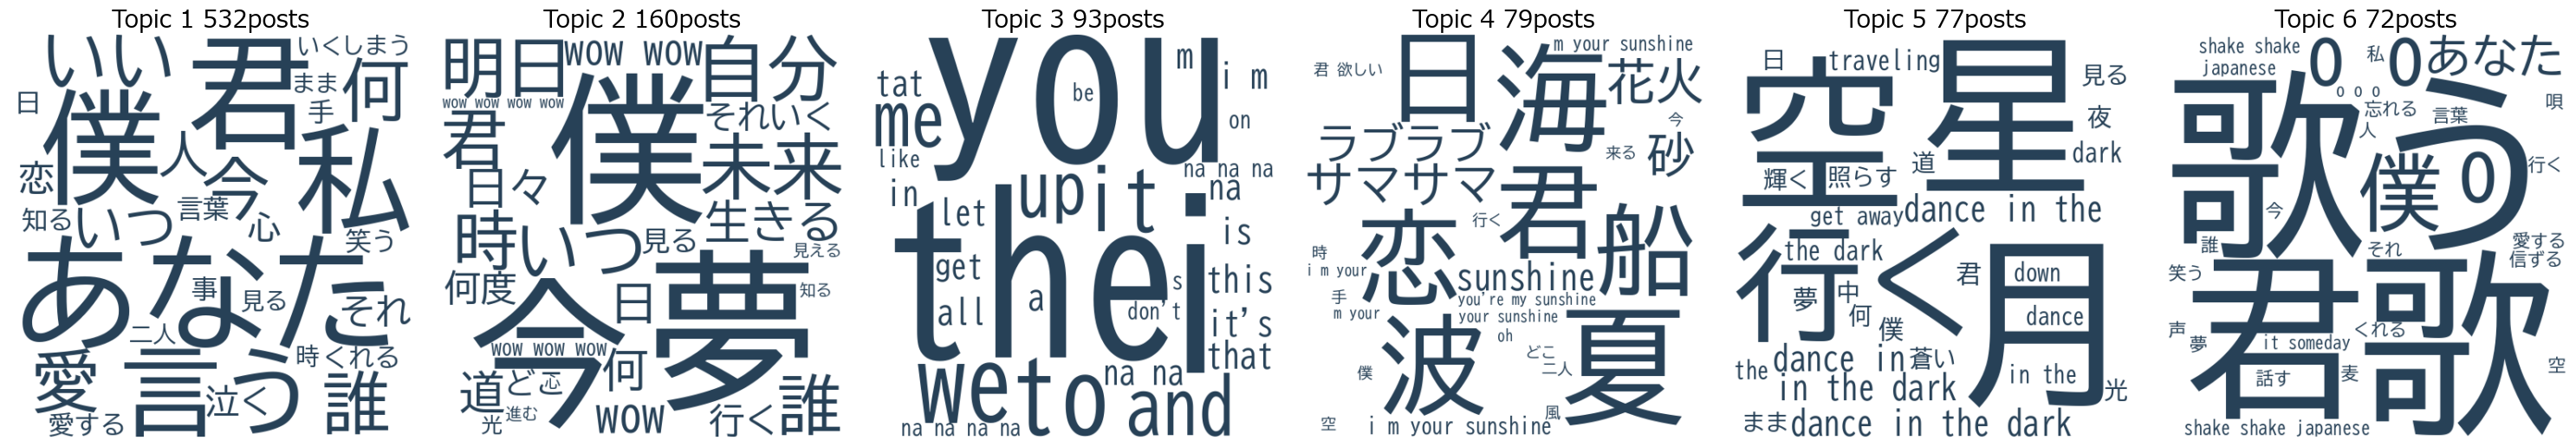

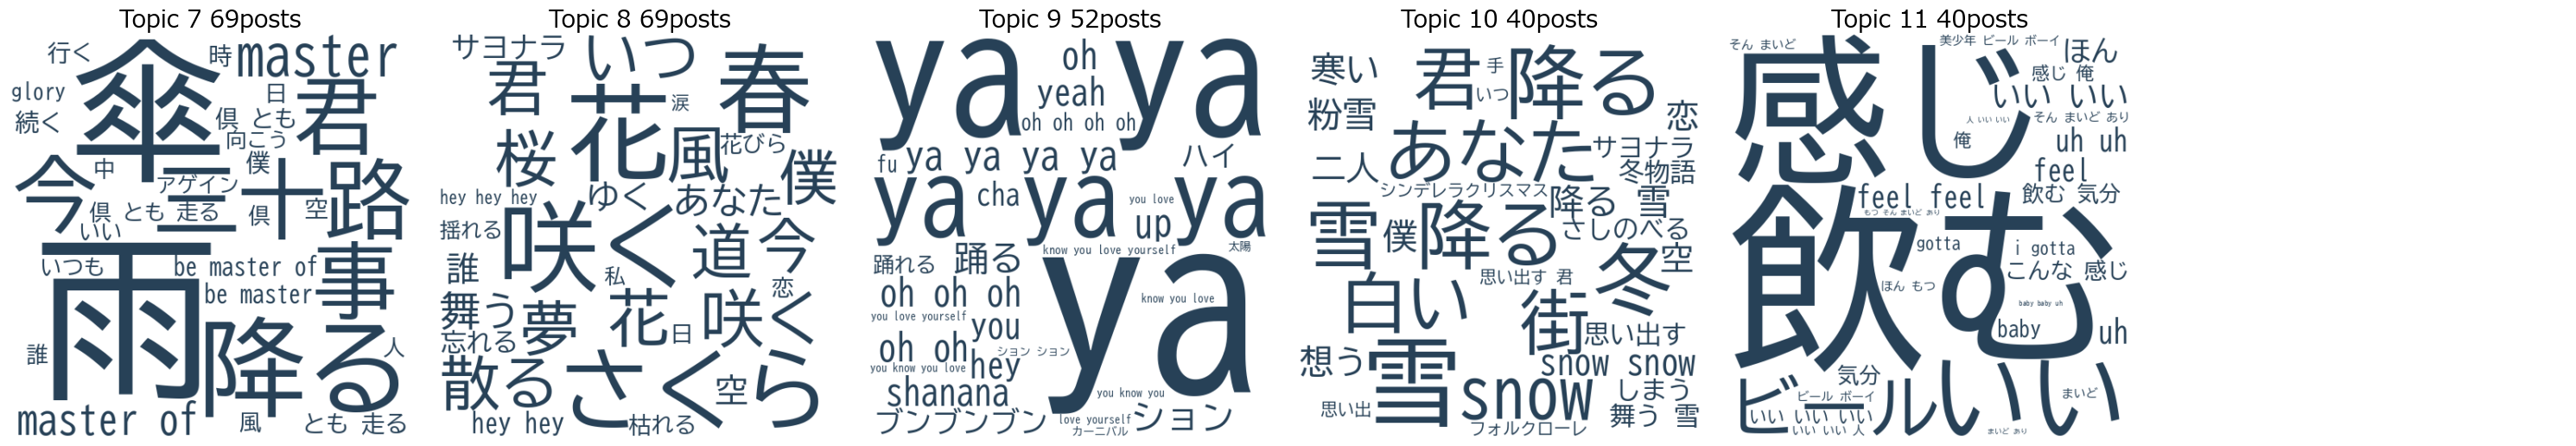

In [ ]:
# from bertopic.vectorizers import ClassTfidfTransformer
# # topic_model = pickle_load(BT_OUT / "fitted_topic_model.pkl")
# # def tknz(txt):
# #     # KEEPPOS = True
# #     KEEPPOS = {"名詞", "形容詞", "動詞", "代名詞", "連体詞", "感動詞"}
# #     NG = set("ない あ あぁ う この あの その ここ そこ する いる ある なる こと".split(" "))
# #     # NG = False
# #     return base_tokenize(
# #         txt,
# #         keep_pos=KEEPPOS,
# #         ng_words=NG,
# #         # max_chars_per_chunk=40000,
# #         # hard_max_chars=45000,
# #         )

# vectorizer = CountVectorizer(
#     tokenizer=tknz,
#     token_pattern=None,
#     lowercase=False,
#     ngram_range=(1, 4),
#     min_df=1,
#     max_df=1.0,
# )
# ctfidf = ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True)
# # rep = MaximalMarginalRelevance(diversity=0.3)  # 多様性を少し上げる
# topic_model.update_topics(
#     docs,
#     vectorizer_model=vectorizer,
#     ctfidf_model=ctfidf,
#     # representation_model=rep,
#     top_n_words=top_n_words,
# )
# # # 結果の確認：トピック一覧／トップワード
# topic_info_ = topic_model.get_topic_info()
# # print(topic_info_.head())

# # # 個別トピックのトップワードを見る
# # print(topic_model.get_topic(0))   # 例: トピックID 0

# # 各トピック上位語 cTF-IDF算出
# topic_words_data = []
# for topic_id in topic_info_["Topic"].tolist():
#     if topic_id == -1:
#         continue
#     words = topic_model.get_topic(topic_id)
#     # words は (単語, 重み) のリスト
#     topic_words_ = pd.DataFrame(words, columns=["word", "weight"])
#     topic_words_["topic_id"] = topic_id
#     topic_words_data.append(topic_words_)
# topic_words_ = pd.concat(topic_words_data,axis=0)
# topic_words_.index.name = 'rank'
# topic_words_ = topic_words_.reset_index()
# # topic_words.to_csv(
# #     BT_OUT / f"topic_words_top{top_n_words}.csv",
# #     index=False,
# #     encoding="utf-8-sig"
# #     )

# topic_size = np.max(topic_info_.Topic) + 1
# from_topic = 1
# ncols = 6
# to_topic = ncols
# while from_topic <= topic_size:
#     show_wc_topics_row(
#             from_topic,
#             to_topic,
#             topic_words_,
#             top_n_words,
#             topic_info_,
#             fontcolor = "#274157",
#         #     savepath = BT_OUT / f"wc_bertopic_output_topic{from_topic}-{to_topic}.png",
#             )
#     from_topic += ncols
#     to_topic += ncols

In [80]:
embeddings = topic_model._extract_embeddings(
    docs,
    method="document",
    verbose=True,
    )

Batches:   0%|          | 0/77 [00:00<?, ?it/s]

In [81]:
import pickle
with open(BT_OUT/"enbeddings.pkl", mode='wb') as f:
    pickle.dump(embeddings, f)